# Decision Tree Models

A decision tree is a set of rules combined in a hierarchical manner:
* Sequence of simple decision rules: one feature and one threshold at a time
* No scaling required for numerical features
* `max_depth` controls the trade-off between under-fitting and over-fitting
* Mostly useful as building block for ensemble models: random forest or gradient boosting  decision trees.

## Decision tree in classification

In the following we will illustrate how decision trees fit data with a simple classification problem using the penguins dataset.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from helper_kit import plot_decision_function

In [3]:
penguins = pd.read_csv('data/penguins_classification.csv')
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"
penguins.sample(3)

,Culmen Length (mm),Culmen Depth (mm),Species
187,42.6,13.7,Gentoo
85,36.3,19.5,Adelie
313,53.5,19.9,Chinstrap


In [4]:
from sklearn.model_selection import train_test_split

data, target = penguins[culmen_columns], penguins[target_column]
data_train, data_test, target_train, target_test = train_test_split(data, target,
                                                                   random_state=0)

range_features = {
    feature_name: (data[feature_name].min() - 1, data[feature_name].max() + 1)
    for feature_name in data.columns }
range_features

{'Culmen Length (mm)': (31.1, 60.6), 'Culmen Depth (mm)': (12.1, 22.5)}

In a previous notebook, we learned that a linear classifier will define a linear separation to split classes using a linear combination of the input features.  
In our 2-dimensional space, it means that a linear classifier will define some oblique lines that best separate our classes. Thus for a linear classifier, we will obtain the following decision boundaries. These boundaries lines indicate where the model changes its prediction from one class to another.

In [5]:
from sklearn.linear_model import LogisticRegression

linear_model = LogisticRegression()
linear_model.fit(data_train, target_train)

LogisticRegression()

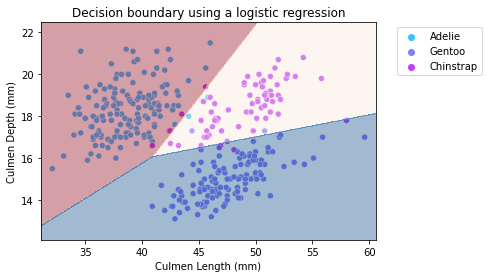

In [6]:
ax = sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
               hue='Species', palette='cool')

plot_decision_function(linear_model, range_features, ax=ax)
# put the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
_ = plt.title("Decision boundary using a logistic regression")

We see that the lines are a combination of the input features since they are not perpendicular a specific axis. This is due to the model parameterization that we saw in the previous notebook, controlled by the model's weights and intercept.

Besides, it seems that the linear model would be a good candidate for such problem as it gives good accuracy:

In [7]:
linear_model.fit(data_train, target_train)
test_score = linear_model.score(data_test, target_test)
print(f"Accuracy of the LogisticRegression: {test_score:.2f}")

Accuracy of the LogisticRegression: 0.98


Unlike linear models, decision trees are non-parametric models: they are not controlled by a mathematical decision function and do not have weights or intercept to be optimized.

Decision trees will partition the space by considering a single feature at a time. Let's illustrate this behavior by having a decision tree make a single split to partition the feature space.

In [8]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=1)
tree.fit(data_train, target_train)

DecisionTreeClassifier(max_depth=1)

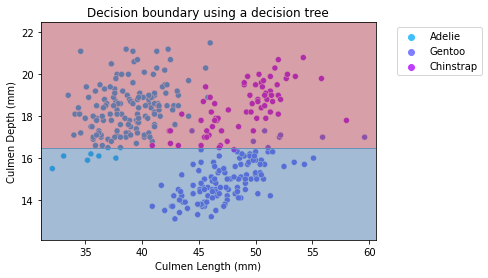

In [11]:
ax = sns.scatterplot(data=penguins, x=culmen_columns[0],
                    y=culmen_columns[1], hue=target_column,
                    palette='cool') 
plot_decision_function(tree, range_features, ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Decision boundary using a decision tree');

The partitions found by the algorithm separates the data along the axis "Culmen Depth", discarding the feature "culmen length". Thus, it highlights that a decision tree does not use a combination of feature when making a split.  
We can look more in depth at the tree structure

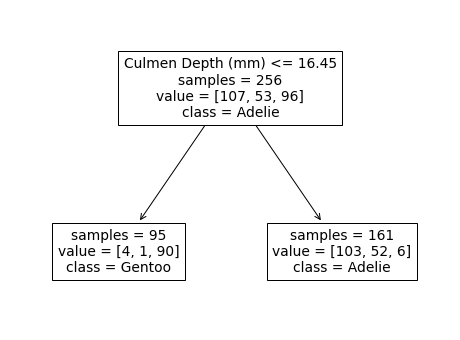

In [13]:
from sklearn.tree import plot_tree
_, ax = plt.subplots(figsize=(8, 6))
plot_tree(tree, feature_names=culmen_columns,
         class_names=tree.classes_, impurity=False, ax=ax);

We see that the split was done the culmen depth feature. The original dataset was subdivided into 2 sets based on the culmen depth.

This partition of the dataset minimizes the class diversities in each sub-partitions. This measure is also known as a **criterion**, and is a settable parameter...

Let's see how our tree would work as a predictor. Let's start to see the class predicted when the culmen depth is inferior to the threshold.

In [14]:
tree.predict([[0, 15]])

array(['Gentoo'], dtype=object)

In [16]:
tree.predict([[0, 17]])

array(['Adelie'], dtype=object)

A decision tree classifier will predict the most represented class within a partition.  

During the training, we have a count of samples in each partition, we can also compute the probability of belonging to a specific class with this partition.

In [17]:
y_pred_proba = tree.predict_proba([[0, 17]])

In [18]:
y_proba_class_0 = pd.Series(y_pred_proba[0], index=tree.classes_)

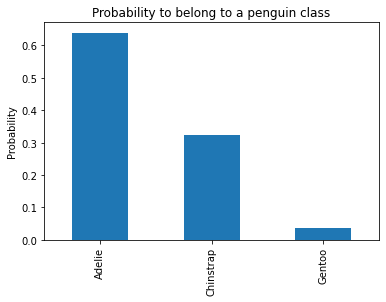

In [19]:
y_proba_class_0.plot.bar()
plt.ylabel("Probability")
_ = plt.title("Probability to belong to a penguin class")

In [20]:
tree.fit(data_train, target_train)
test_score = tree.score(data_test, target_test)
print(f"Accuracy of the DecisionTreeClassifier: {test_score:.2f}")

Accuracy of the DecisionTreeClassifier: 0.78


Indeed, it is not a surprise. We saw earlier that a single feature will not be able to separate all three species. However, from the previous analysis we saw that by using both features we should be able to get fairly good results.